In [56]:
import quandl
import os
import pandas as pd
import pickle
import bs4 as bs
import requests
from sklearn import preprocessing

In [58]:
quandl.ApiConfig.api_key='4sg3wyxBDeENg3R3W3qt'
startdate="2014-04-22"
enddate="2021-04-19"

In [77]:
def nifty_50_list():
    resp = requests.get('https://en.wikipedia.org/wiki/NIFTY_50')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    #Goto wiki page and do inspect element
    # Find all the table tags whose class is wikitable sortable, insie that there is 'tbody' tag
    # and extract all the data from there 
    table = soup.find('table', {'class': 'wikitable sortable'},'tbody')
    print(table)
nifty_50_list()

<table class="wikitable sortable" id="constituents" style="font-size:85%">
<tbody><tr>
<th>Company Name</th>
<th>Symbol</th>
<th>Sector
</th></tr>
<tr>
<td><a href="/wiki/Adani_Ports_%26_SEZ" title="Adani Ports &amp; SEZ">Adani Ports</a></td>
<td>ADANIPORTS.NS</td>
<td>Infrastructure
</td></tr>
<tr>
<td><a href="/wiki/Asian_Paints" title="Asian Paints">Asian Paints</a></td>
<td>ASIANPAINT.NS</td>
<td>Consumer Goods
</td></tr>
<tr>
<td><a href="/wiki/Axis_Bank" title="Axis Bank">Axis Bank</a></td>
<td>AXISBANK.NS</td>
<td>Banking
</td></tr>
<tr>
<td><a href="/wiki/Bajaj_Auto" title="Bajaj Auto">Bajaj Auto</a></td>
<td>BAJAJ-AUTO.NS</td>
<td>Automobile
</td></tr>
<tr>
<td><a href="/wiki/Bajaj_Finance" title="Bajaj Finance">Bajaj Finance</a></td>
<td>BAJFINANCE.NS</td>
<td>Financial Services
</td></tr>
<tr>
<td><a href="/wiki/Bajaj_Finserv" title="Bajaj Finserv">Bajaj Finserv</a></td>
<td>BAJAJFINSV.NS</td>
<td>Financial Services
</td></tr>
<tr>
<td><a href="/wiki/Bharti_Airtel" title="Bh

In [78]:
def nifty_50_list():
    resp = requests.get('https://en.wikipedia.org/wiki/NIFTY_50')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    #Goto wiki page and do inspect element
    # Find all the table tags whose class is wikitable sortable, insie that there is 'tbody' tag
    # and extract all the data from there 
    table = soup.find('table', {'class': 'wikitable sortable'},'tbody')

    tickers = []
    for row in table.findAll('tr')[1:]: # 0th <tr> tag contains Company,Sysmbol,Sector.. Not needed
        ticker = row.findAll('td')[1].text  #First <td> tag data
        print(ticker.split('.')[0])
nifty_50_list()

ADANIPORTS
ASIANPAINT
AXISBANK
BAJAJ-AUTO
BAJFINANCE
BAJAJFINSV
BHARTIARTL
BPCL
BRITANNIA
CIPLA
COALINDIA
DIVISLAB
DRREDDY
EICHERMOT
GRASIM
HCLTECH
HDFC
HDFCBANK
HDFCLIFE
HEROMOTOCO
HINDALCO
HINDUNILVR
ICICIBANK
INDUSINDBK
INFY
IOC
ITC
JSWSTEEL
KOTAKBANK
LT
M&M
MARUTI
NESTLEIND
NTPC
ONGC
POWERGRID
RELIANCE
SBIN
SBILIFE
SHREECEM
SUNPHARMA
TATAMOTORS
TATASTEEL
TCS
TATACONSUM
TECHM
TITAN
ULTRACEMCO
UPL
WIPRO


In [63]:
#ticker symbol - The abbreviation representing companies in the stock market. Example: Google --> GOOGL, Apple---> AAPL

In [93]:
def nifty_50_list():
    resp = requests.get('https://en.wikipedia.org/wiki/NIFTY_50')
    soup = bs.BeautifulSoup(resp.text, 'lxml')

    table = soup.find('table', {'class': 'wikitable sortable'},'tbody')

    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[1].text
        # print(f"ticker{ticker}")
        tickers.append(ticker.split('.')[0])

    with open("nifty50_list.pickle","wb") as f:
        pickle.dump(tickers,f)
    
    #Adding it manually since ticker name obtained from Wikipedia contains a hypen whereas quandl code expects an underscore
    tickers = list(map(lambda x: x.replace("BAJAJ-AUTO","BAJAJ_AUTO"), tickers))
    #Adding it manually since quandl code is different than the ticker symbol obtained from Wiki which is M&M
    tickers = list(map(lambda x: x.replace("M&M","MM"), tickers))
    #Fetching data for NIFTY50 index whose price we want to PREDICT
    tickers.append('NIFTY_50')
    # We will remove below ones since data ins't available
   # tickers.remove('VEDL')
   # tickers.remove('UPL')
#     tickers.remove('IBULHSGFIN')
    return tickers

In [94]:
def get_nifty50_list(scrap=False):
    if scrap:
        tickers=nifty_50_list()
    else:
        with open("nifty50_list.pickle","rb") as f:
            tickers=pickle.load(f)
    return tickers

In [95]:

def getStockdataFromQuandl(ticker):
    quandl_code="NSE/"+ticker
    try:
        if not os.path.exists(f'stocks_data/{ticker}.csv'):
          data=quandl.get(quandl_code,start_date=startdate,end_date=enddate)
          data.to_csv(f'stocks_data/{ticker}.csv')
        else:
            print(f"stock data for {ticker} already exists")
    except quandl.errors.quandl_error.NotFoundError as e:
        print(ticker)
        print(str(e))

In [96]:
def load():
    tickers=get_nifty50_list(True)
    df=pd.DataFrame()
    for ticker in tickers:
        getStockdataFromQuandl(ticker) # Store them in csv
        try:
            data=pd.read_csv(f'stocks_data/{ticker}.csv')
            
            # Due to column name mismatches we are renaming it from stock_data/...csv to our dataframe
            if(ticker == "NIFTY_50"):
                data.rename(columns={'Close':f"{ticker}_Close",'Shares Traded':f"{ticker}_Volume"},inplace=True)
            else:
                data.rename(columns={'Close':f"{ticker}_Close",'Total Trade Quantity':f"{ticker}_Volume"},inplace=True)
            
            df=pd.concat([df,data[f'{ticker}_Volume'],data[f'{ticker}_Close']],axis=1)
        except Exception as e:
            print(f"couldn't find {ticker}")
            print(str(e))
    df.to_csv('nifty50_closingprices.csv')
    df.dropna(inplace=True)
    return df

In [90]:
getStockdataFromQuandl('INFY')

In [97]:
load()

stock data for INFY already exists
TATACONSUM
(Status 404) (Quandl Error QECx02) You have submitted an incorrect Quandl code. Please check your Quandl codes and try again.
couldn't find TATACONSUM
[Errno 2] File stocks_data/TATACONSUM.csv does not exist: 'stocks_data/TATACONSUM.csv'


,ADANIPORTS_Volume,ADANIPORTS_Close,ASIANPAINT_Volume,ASIANPAINT_Close,AXISBANK_Volume,AXISBANK_Close,BAJAJ_AUTO_Volume,BAJAJ_AUTO_Close,BAJFINANCE_Volume,BAJFINANCE_Close,...,TITAN_Volume,TITAN_Close,ULTRACEMCO_Volume,ULTRACEMCO_Close,UPL_Volume,UPL_Close,WIPRO_Volume,WIPRO_Close,NIFTY_50_Volume,NIFTY_50_Close
0,3848936.0,204.80,405176.0,536.40,994573.0,1500.10,179445.0,2003.35,165329.0,1765.15,...,931899.0,261.25,159728.0,2202.10,1477618.0,218.50,4252307.0,530.55,114693049.0,6815.35
1,7702502.0,204.45,866527.0,529.60,1633806.0,1519.80,362968.0,2004.65,50048.0,1826.75,...,3942894.0,255.00,340327.0,2169.70,2215281.0,214.70,4505036.0,524.70,182972972.0,6840.80
2,5808334.0,198.70,512656.0,514.95,2457432.0,1532.70,404437.0,1996.05,22664.0,1813.00,...,724290.0,258.20,369536.0,2079.60,11856099.0,230.35,3071291.0,519.25,154320793.0,6782.75
3,6111039.0,192.15,1434257.0,500.55,1773777.0,1529.55,356855.0,1985.00,19005.0,1856.80,...,400140.0,258.30,246765.0,2050.75,31256718.0,276.60,3187852.0,529.60,118162668.0,6761.25
4,4973177.0,191.55,871746.0,497.60,1196919.0,1528.40,399483.0,1939.50,29549.0,1872.55,...,516059.0,260.00,237064.0,2066.50,10854602.0,275.15,2276633.0,524.80,115511531.0,6715.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,2647500.0,302.15,795683.0,748.00,6286247.0,553.60,372632.0,2224.20,24255.0,4472.70,...,275247.0,352.95,110182.0,2809.85,1713261.0,534.60,1138456.0,555.00,140075743.0,8044.15
276,2724447.0,306.55,998511.0,735.70,5252618.0,558.70,296262.0,2190.70,56110.0,4582.35,...,400693.0,359.55,147353.0,2810.35,2301317.0,516.40,1192589.0,543.55,140217686.0,8022.40
277,2282770.0,312.95,803748.0,739.15,7919473.0,564.50,409711.0,2253.15,22798.0,4553.20,...,423122.0,364.70,172608.0,2804.55,1466414.0,520.75,1784344.0,562.75,141030200.0,8124.45
278,3718393.0,304.25,1453089.0,708.40,7608358.0,546.75,350425.0,2213.55,85942.0,4665.30,...,402824.0,353.70,264043.0,2701.65,1275865.0,506.55,1997726.0,546.05,171348959.0,7965.35


,Unnamed: 0,ADANIPORTS_Volume,ADANIPORTS_Close,ASIANPAINT_Volume,ASIANPAINT_Close,AXISBANK_Volume,AXISBANK_Close,BAJAJ_AUTO_Volume,BAJAJ_AUTO_Close,BAJFINANCE_Volume,...,TITAN_Volume,TITAN_Close,ULTRACEMCO_Volume,ULTRACEMCO_Close,UPL_Volume,UPL_Close,WIPRO_Volume,WIPRO_Close,NIFTY_50_Volume,NIFTY_50_Close
0,0,3848936.0,204.80,405176.0,536.40,994573.0,1500.10,179445.0,2003.35,165329.0,...,931899.0,261.25,159728.0,2202.10,1477618.0,218.50,4252307.0,530.55,114693049.0,6815.35
1,1,7702502.0,204.45,866527.0,529.60,1633806.0,1519.80,362968.0,2004.65,50048.0,...,3942894.0,255.00,340327.0,2169.70,2215281.0,214.70,4505036.0,524.70,182972972.0,6840.80
2,2,5808334.0,198.70,512656.0,514.95,2457432.0,1532.70,404437.0,1996.05,22664.0,...,724290.0,258.20,369536.0,2079.60,11856099.0,230.35,3071291.0,519.25,154320793.0,6782.75
3,3,6111039.0,192.15,1434257.0,500.55,1773777.0,1529.55,356855.0,1985.00,19005.0,...,400140.0,258.30,246765.0,2050.75,31256718.0,276.60,3187852.0,529.60,118162668.0,6761.25
4,4,4973177.0,191.55,871746.0,497.60,1196919.0,1528.40,399483.0,1939.50,29549.0,...,516059.0,260.00,237064.0,2066.50,10854602.0,275.15,2276633.0,524.80,115511531.0,6715.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1157,1157,2062181.0,387.70,698593.0,1373.05,6030093.0,619.90,406069.0,2720.15,1453327.0,...,4917511.0,931.00,157905.0,3990.95,1499975.0,758.25,2136121.0,330.85,NaN,NaN
1158,1158,1233249.0,389.00,664707.0,1371.55,12179223.0,627.30,304150.0,2726.65,917872.0,...,2064502.0,928.00,92921.0,4009.20,1610248.0,753.50,1513704.0,326.65,NaN,NaN
1159,1159,1506543.0,381.30,1233780.0,1383.30,12386281.0,620.05,599274.0,2692.00,1304915.0,...,2672587.0,932.15,143828.0,4006.10,1308043.0,756.50,3308303.0,325.55,NaN,NaN
1160,1160,1902063.0,378.10,1636293.0,1388.30,13228602.0,607.95,310511.0,2701.35,1282478.0,...,3292918.0,931.20,223538.0,3900.05,1053144.0,746.65,3542281.0,325.50,NaN,NaN


In [101]:
SERIES_LENGTH=30
PREDICT_LENGTH=7

In [102]:
TICKER="NIFTY_50"
def scale_data(df):
    for column in df.columns:
        df[column] = preprocessing.scale(df[column].values)
    return df

In [103]:
import numpy as np
def process_data(df):
    df["nifty_future_price"]=df[f"{TICKER}_Close"].shift(-PREDICT_LENGTH) # Shift it by 7 days

    #Dropping any Nan values
    df.dropna(inplace=True)

    df["Label"]=np.where(df["nifty_future_price"]>=df["NIFTY_50_Close"],1,0)
    #print(f"df with future column {df[:5]}")
    #dropping 'nifty_future_price'  columns as it is no longer required
    df.drop('nifty_future_price',1,inplace=True) # must be dropped
    df.to_csv('nifty50_future_label.csv')

    sequence=[]
    # We want to scale the data except the label part since it is already 0 and 1
    temp=df.loc[:, df.columns != 'Label']
    temp=scale_data(temp)
    # print(f"temp{temp[:30]}")
    for i in range (len(temp)-SERIES_LENGTH):
       sequence.append([np.array(temp[i:i+SERIES_LENGTH]),df.iloc[i+SERIES_LENGTH,-1]]) # iloc part is to take last column data i.e. labels

    np.random.shuffle(sequence)

    #Now we will count the sells and buys to balance the data
    # Algorithm : whichever count is less, we will take up the data upto that
    X=[]
    y=[]
    buy=[]
    sell=[]
    for seq ,label in sequence:
        if label == 0:
            sell.append([seq,label])
        else:
            buy.append([seq,label])
            
    # print(f"buy :{buy[:10]}")
    # print(f"sell :{sell[:10]}")
    
    buys=len(buy)
    sells=len(sell)
    print(f"original buys:{buys} original sells:{sells}")
    if(buys<sells):
        buy=buy[:buys]
        sell=sell[:buys]
    else:
        buy=buy[:sells]
        sell=sell[:sells]

    print(f"buys:{len(buy)} sells:{len(sell)}")
    # Concat the buys an sells and shuffle it out again
    sequence=buy+sell

    np.random.shuffle(sequence)


    for seq ,label in sequence:
        X.append(seq)
        y.append(label)

    return np.array(X),np.array(y)

In [104]:
df=load()


stock data for ADANIPORTS already exists
stock data for ASIANPAINT already exists
stock data for AXISBANK already exists
stock data for BAJAJ_AUTO already exists
stock data for BAJFINANCE already exists
stock data for BAJAJFINSV already exists
stock data for BHARTIARTL already exists
stock data for BPCL already exists
stock data for BRITANNIA already exists
stock data for CIPLA already exists
stock data for COALINDIA already exists
stock data for DIVISLAB already exists
stock data for DRREDDY already exists
stock data for EICHERMOT already exists
stock data for GRASIM already exists
stock data for HCLTECH already exists
stock data for HDFC already exists
stock data for HDFCBANK already exists
stock data for HDFCLIFE already exists
stock data for HEROMOTOCO already exists
stock data for HINDALCO already exists
stock data for HINDUNILVR already exists
stock data for ICICIBANK already exists
stock data for INDUSINDBK already exists
stock data for INFY already exists
stock data for IOC alr

In [112]:
df=load()

stock data for ADANIPORTS already exists
stock data for ASIANPAINT already exists
stock data for AXISBANK already exists
stock data for BAJAJ_AUTO already exists
stock data for BAJFINANCE already exists
stock data for BAJAJFINSV already exists
stock data for BHARTIARTL already exists
stock data for BPCL already exists
stock data for BRITANNIA already exists
stock data for CIPLA already exists
stock data for COALINDIA already exists
stock data for DIVISLAB already exists
stock data for DRREDDY already exists
stock data for EICHERMOT already exists
stock data for GRASIM already exists
stock data for HCLTECH already exists
stock data for HDFC already exists
stock data for HDFCBANK already exists
stock data for HDFCLIFE already exists
stock data for HEROMOTOCO already exists
stock data for HINDALCO already exists
stock data for HINDUNILVR already exists
stock data for ICICIBANK already exists
stock data for INDUSINDBK already exists
stock data for INFY already exists
stock data for IOC alr

In [113]:
process_data(df)

original buys:131 original sells:111
buys:111 sells:111
<ipython-input-102-1bcd616a9c68>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = preprocessing.scale(df[column].values)
<ipython-input-102-1bcd616a9c68>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = preprocessing.scale(df[column].values)
<ipython-input-102-1bcd616a9c68>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

(array([[[ 2.43196985e-01, -1.10106051e+00, -7.59310872e-01, ...,
          -1.78437529e+00,  8.86850008e-01, -1.28160661e+00],
         [ 5.56846434e-01, -1.15711133e+00, -9.48560309e-02, ...,
          -1.57669247e+00,  1.84438631e+00, -1.14700385e+00],
         [ 1.50740094e+00, -7.49468990e-01,  3.86893319e-01, ...,
          -1.38534426e+00,  1.79734845e+00, -9.42242784e-01],
         ...,
         [ 1.13032501e+00, -9.77493925e-01, -5.96694047e-01, ...,
          -3.65598285e-01,  5.33518158e-01, -1.17416794e+00],
         [ 7.77297437e-04, -8.73035575e-01, -7.63907086e-01, ...,
          -6.93457116e-01, -5.54825372e-01, -1.18437789e+00],
         [ 3.12194933e-01, -6.14437465e-01, -8.81825852e-01, ...,
          -7.62295803e-01, -8.28410218e-01, -1.04855743e+00]],
 
        [[-4.50893151e-02,  1.62630748e-01, -6.25227476e-01, ...,
           3.06453980e-01, -1.14027693e+00,  1.44953223e-02],
         [-5.69151659e-01,  1.62630748e-01, -7.18666251e-01, ...,
           1.27940097

In [114]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,LSTM,BatchNormalization,Conv1D,MaxPooling1D
import matplotlib.pyplot as plt
from sklearn import preprocessing
import pandas as pd

In [130]:
df=load()


stock data for ADANIPORTS already exists
stock data for ASIANPAINT already exists
stock data for AXISBANK already exists
stock data for BAJAJ_AUTO already exists
stock data for BAJFINANCE already exists
stock data for BAJAJFINSV already exists
stock data for BHARTIARTL already exists
stock data for BPCL already exists
stock data for BRITANNIA already exists
stock data for CIPLA already exists
stock data for COALINDIA already exists
stock data for DIVISLAB already exists
stock data for DRREDDY already exists
stock data for EICHERMOT already exists
stock data for GRASIM already exists
stock data for HCLTECH already exists
stock data for HDFC already exists
stock data for HDFCBANK already exists
stock data for HDFCLIFE already exists
stock data for HEROMOTOCO already exists
stock data for HINDALCO already exists
stock data for HINDUNILVR already exists
stock data for ICICIBANK already exists
stock data for INDUSINDBK already exists
stock data for INFY already exists
stock data for IOC alr

In [131]:
training_size=0.8
spilt_point=int(training_size*len(df))
#splitting data for training and testing in ratio 80:20
train_df=df[:spilt_point]
test_df=df[spilt_point:]

print(f"train_df {train_df[:5]}")
print("="*100)
print(f"test_df {test_df[:5]}")

train_df    ADANIPORTS_Volume  ADANIPORTS_Close  ASIANPAINT_Volume  ASIANPAINT_Close  \
0          3848936.0            204.80           405176.0            536.40   
1          7702502.0            204.45           866527.0            529.60   
2          5808334.0            198.70           512656.0            514.95   
3          6111039.0            192.15          1434257.0            500.55   
4          4973177.0            191.55           871746.0            497.60   

   AXISBANK_Volume  AXISBANK_Close  BAJAJ_AUTO_Volume  BAJAJ_AUTO_Close  \
0         994573.0         1500.10           179445.0           2003.35   
1        1633806.0         1519.80           362968.0           2004.65   
2        2457432.0         1532.70           404437.0           1996.05   
3        1773777.0         1529.55           356855.0           1985.00   
4        1196919.0         1528.40           399483.0           1939.50   

   BAJFINANCE_Volume  BAJFINANCE_Close  ...  TITAN_Volume  TITAN_

In [132]:



import warnings
warnings.filterwarnings("ignore")

train_x,train_y=process_data(train_df)

test_x,test_y=process_data(test_df)

original buys:111 original sells:75
buys:75 sells:75
original buys:8 original sells:11
buys:8 sells:8


In [133]:

print('X_train :',train_x.shape)
print('y_train :',train_y.shape)
print('X_test :',test_x.shape)
print('y_test :',test_y.shape)

X_train : (150, 30, 100)
y_train : (150,)
X_test : (16, 30, 100)
y_test : (16,)


In [134]:

NAME="NIFTY50PRED"
BATCH_SIZE=64
EPOCHS=15

In [135]:
to_categorical([0,1])


NameError: name 'to_categorical' is not defined

In [136]:
from keras.utils import plot_model

def build_model():

    model=Sequential()
    model.add(LSTM(256,input_shape=(train_x.shape[1:]),return_sequences=True))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())

    model.add(LSTM(256,return_sequences=True))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())

    model.add(LSTM(256,return_sequences=False))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())

    model.add(Dense(32,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1,activation='sigmoid'))


    model.compile(loss='binary_crossentropy',optimizer="adam",metrics=['accuracy'])


    history=model.fit(train_x,train_y,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_data=(test_x,test_y))
    score=model.evaluate(test_x,test_y)
    print("Validation accuracy percentage",score[1]*100)
    print("Validation loss percentage",score[0]*100)
    return model

In [137]:
model = build_model()


Epoch 1/15
3/3 [==============================] - 2s 532ms/step - loss: 0.8009 - accuracy: 0.5800 - val_loss: 0.7136 - val_accuracy: 0.3750
Epoch 2/15
3/3 [==============================] - 0s 149ms/step - loss: 0.8567 - accuracy: 0.6133 - val_loss: 0.7146 - val_accuracy: 0.3125
Epoch 3/15
3/3 [==============================] - 0s 149ms/step - loss: 0.6343 - accuracy: 0.6400 - val_loss: 0.7206 - val_accuracy: 0.2500
Epoch 4/15
3/3 [==============================] - 0s 152ms/step - loss: 0.5351 - accuracy: 0.7333 - val_loss: 0.7272 - val_accuracy: 0.3125
Epoch 5/15
3/3 [==============================] - 0s 148ms/step - loss: 0.4397 - accuracy: 0.7467 - val_loss: 0.7287 - val_accuracy: 0.3750
Epoch 6/15
3/3 [==============================] - 0s 150ms/step - loss: 0.4820 - accuracy: 0.7333 - val_loss: 0.7276 - val_accuracy: 0.3750
Epoch 7/15
3/3 [==============================] - 0s 147ms/step - loss: 0.4122 - accuracy: 0.8067 - val_loss: 0.7366 - val_accuracy: 0.3750
Epoch 8/15
3/3 [====

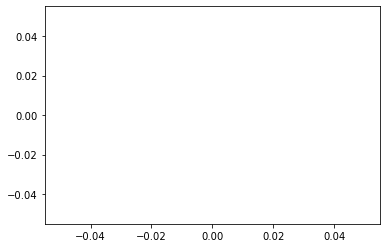

In [142]:
prediction=model.predict(test_x)
plt.plot(prediction[30:50],color='green',label='predicted_data')
plt.plot(test_y[30:50],color='blue',label='actual_data')

plt.show()